In [66]:
# Подключение модулей
from keras.models import Sequential, Model
from keras.layers import Lambda, Input
from keras.backend import tf as ktf
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.datasets import fashion_mnist 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import cv2, numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
#загрузили данные
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [57]:
# Размер изображений
img_width, img_height = 28, 28
# Размер мини-выборки
batch_size = 100
# Кол-во изображений для обучения
nb_train_samples = 60000
# Кол-во изображений для теста
nb_test_samples = 10000

In [58]:
# Нормализируем значения из 0-255 к 0.0-1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = np.stack((x_train,)*3, axis=-1)
x_test = np.stack((x_test,)*3, axis=-1)

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [59]:
# Создание экземпляра модели сети VGG16
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# weights - веса предварительно обученной сети
# include_top = false означает, что мы загружаем только сверточную часть сети, без квалификационной
# input_shape - размер тензора

# Сверточную часть сети обучать не надо
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
  if layer.name == 'block1_conv1':
    trainable = True
  layer.trainable = trainable

vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [60]:
# 3 channel images of arbitrary shape
inp = Input(shape=(None, None, 3))
out = Lambda(lambda image: ktf.image.resize(image, (128, 128)))(inp)

inputLayer = Model(inputs=inp, outputs=out, name="resizer")
inputLayer.summary()

Model: "resizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Создание модели составной сети
model = Sequential()
# Добавляем слой для преобразования размера изображения
model.add(inputLayer)
# Добавляем сверточные слои
model.add(vgg16_net)
# Преобразуем двумерный массив MobileNet в одномерный
model.add(Flatten())
# Полносвязный слой
model.add(Dense(256, activation='relu'))
# Слой регуляризации (для предотвращения переобучения)
model.add(Dropout(0.5))
# Кол-во классов
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizer (Functional)         (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total params: 16,814,666
Trainable params: 16,814,666
Non-trainable params: 0
__________________________________________

In [62]:
# Компилируем составную сеть
epochs = 5
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [75]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = epochs, batch_size=300)


Epoch 1/5
200/200 [==============================] - 272s 1s/step - loss: 0.2872 - accuracy: 0.8989 - val_loss: 0.2265 - val_accuracy: 0.9187
Epoch 2/5
200/200 [==============================] - 258s 1s/step - loss: 0.2039 - accuracy: 0.9280 - val_loss: 0.1997 - val_accuracy: 0.9293
Epoch 3/5
200/200 [==============================] - 260s 1s/step - loss: 0.1754 - accuracy: 0.9376 - val_loss: 0.1863 - val_accuracy: 0.9317
Epoch 4/5
200/200 [==============================] - 260s 1s/step - loss: 0.1569 - accuracy: 0.9450 - val_loss: 0.1804 - val_accuracy: 0.9354
Epoch 5/5
200/200 [==============================] - 260s 1s/step - loss: 0.1479 - accuracy: 0.9473 - val_loss: 0.1817 - val_accuracy: 0.9343


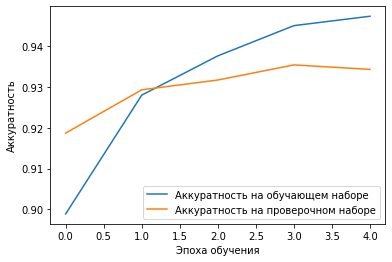

In [78]:
plt.plot(history.history['accuracy'], label='Аккуратность на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Аккуратность на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Аккуратность')
plt.legend()
plt.show()

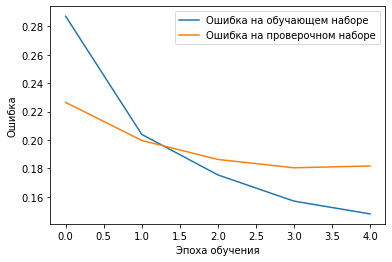

In [77]:
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [79]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 93.43%
